<h1>Milestone 1 </h1>

In [ ]:
!pip install pdf2image Pillow
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 2s (91.7 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.10_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.10) ...
Setting up poppler-utils (22.02.0-2ubuntu0.10) ...
Processing triggers for man-db (2.10.2-1) ...


✅ Original loaded: (208, 256, 256) labels: (208,)
Train set: (166, 256, 256, 1) Test set: (42, 256, 256, 1)


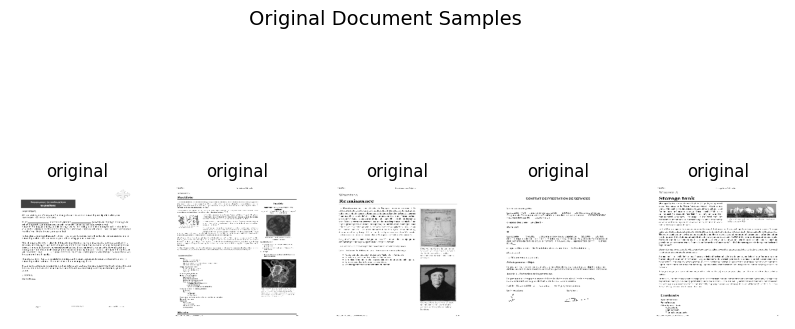

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pdf2image import convert_from_path

IMG_SIZE = (256, 256)

def load_pdfs_from_folder(folder, label):
    images, labels = [], []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".pdf"):
                pdf_path = os.path.join(root, file)
                try:
                    pages = convert_from_path(pdf_path, dpi=200)  # convert each page
                    for page in pages:
                        img = np.array(page.convert("L"))  # grayscale
                        img = cv2.resize(img, IMG_SIZE)
                        img = img / 255.0
                        images.append(img)
                        labels.append(label)
                except Exception as e:
                    print("❌ Could not read:", pdf_path, "| Error:", e)
    return np.array(images), np.array(labels)

#  Path to Original Documents (PDFs)
original_path = "/content/drive/MyDrive/Supatlantique/Originals-20250827T101214Z-1-001"

original_imgs, original_labels = load_pdfs_from_folder(original_path, "original")

print("✅ Original loaded:", original_imgs.shape, "labels:", original_labels.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    original_imgs.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1),
    original_labels,
    test_size=0.2,
    random_state=42,
    stratify=original_labels
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)

# Show some samples
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i].reshape(IMG_SIZE), cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")
plt.suptitle("Original Document Samples", fontsize=14)
plt.show()


📂 Loaded 22 flatfield images from /content/drive/MyDrive/Supatlantique/Flatfield-20250827T100345Z-1-001/Flatfield
📄 Loaded 208 original pages from PDFs in /content/drive/MyDrive/Supatlantique/Originals-20250827T101214Z-1-001
📂 Loaded 134 official images from /content/drive/MyDrive/Supatlantique/Official-20250827T105543Z-1-007
📂 Loaded 85 tampered images from /content/drive/MyDrive/Supatlantique/Tampered images-20250827T122103Z-1-002
📂 Loaded 12 wikipedia images from /content/drive/MyDrive/Supatlantique/Wikipedia-20250827T122205Z-1-015

✅ Final Combined Dataset Loaded

📊 Combined Dataset Summary:
   - flatfield: 22 samples
   - original: 208 samples
   - official: 134 samples
   - tampered: 85 samples
   - wikipedia: 12 samples
   Total: 461 

📈 Train set: (368, 256, 256, 1), Test set: (93, 256, 256, 1)


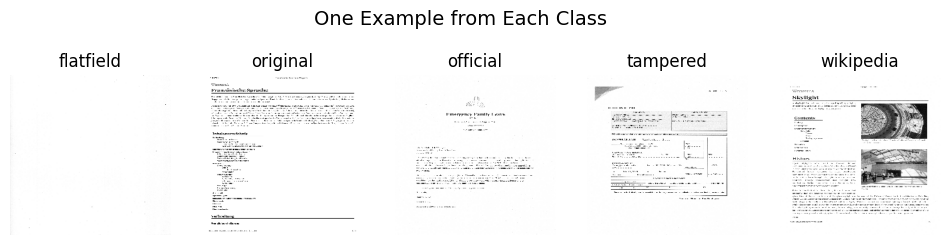

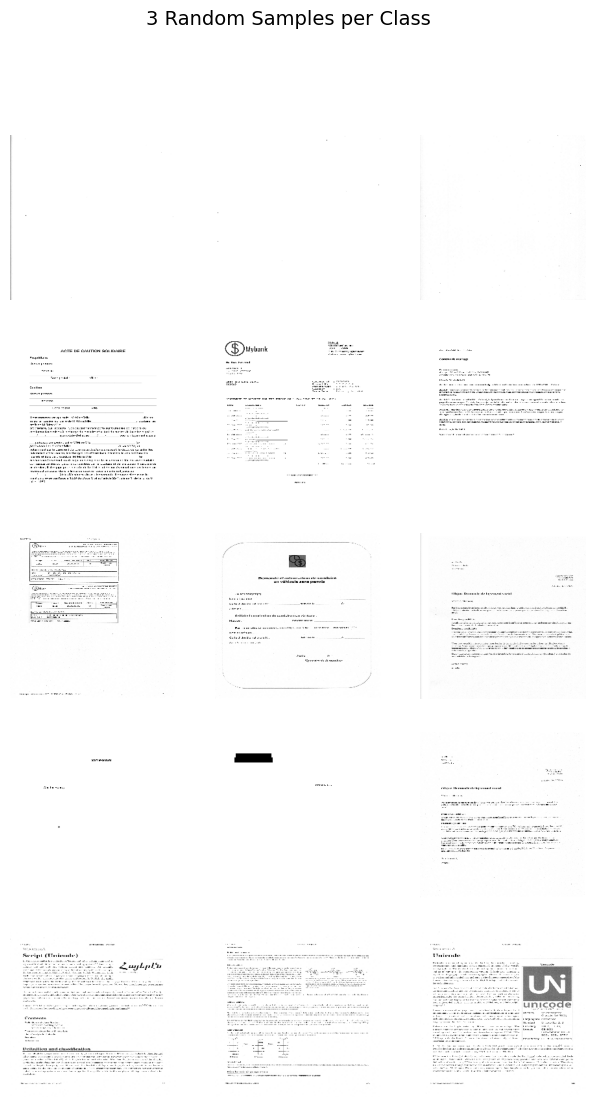

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pdf2image import convert_from_path
from collections import Counter
import random

# Global image size
IMG_SIZE = (256, 256)

def load_images_from_folder(folder, label):
    """Load tif/jpg/png images from folder."""
    images, labels = [], []
    if not os.path.exists(folder):
        print(f"⚠️ Warning: Image folder '{folder}' not found. Skipping.")
        return np.array(images), np.array(labels)

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.startswith("._"):  # skip MacOS junk files
                continue
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print("❌ Could not read:", img_path)
                    continue
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0
                images.append(img)
                labels.append(label)
    print(f"📂 Loaded {len(images)} {label} images from {folder}")
    return np.array(images), np.array(labels)

def load_pdfs_from_folder(folder, label):
    """Load PDFs (convert each page into grayscale image)."""
    images, labels = [], []
    if not os.path.exists(folder):
        print(f"⚠️ Warning: PDF folder '{folder}' not found. Skipping.")
        return np.array(images), np.array(labels)

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".pdf"):
                pdf_path = os.path.join(root, file)
                try:
                    pages = convert_from_path(pdf_path, dpi=200)
                    for page_num, page in enumerate(pages):
                        img = np.array(page.convert("L"))  # grayscale
                        img = cv2.resize(img, IMG_SIZE)
                        img = img / 255.0
                        images.append(img)
                        labels.append(label)
                except Exception as e:
                    print("❌ Could not read:", pdf_path, "| Error:", e)
    print(f"📄 Loaded {len(images)} {label} pages from PDFs in {folder}")
    return np.array(images), np.array(labels)

def print_dataset_summary(labels, name):
    """Print summary statistics for a dataset."""
    counter = Counter(labels)
    print(f"\n📊 {name} Dataset Summary:")
    for cls, count in counter.items():
        print(f"   - {cls}: {count} samples")
    print("   Total:", sum(counter.values()), "\n")


def show_samples_per_class(X, y, classes, title):
    """Show one sample per class."""
    plt.figure(figsize=(12, 3))
    for idx, cls in enumerate(classes):
        indices = np.where(y == cls)[0]
        if len(indices) == 0:
            continue
        i = indices[0]
        plt.subplot(1, len(classes), idx+1)
        plt.imshow(X[i].reshape(IMG_SIZE), cmap="gray")
        plt.title(cls)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

def show_multiple_samples_per_class(X, y, classes, n=3, title="Samples per class"):
    """Show N random samples per class."""
    plt.figure(figsize=(n*2.5, len(classes)*2.5))
    for row, cls in enumerate(classes):
        indices = np.where(y == cls)[0]
        if len(indices) == 0:
            continue
        chosen = random.sample(list(indices), min(n, len(indices)))
        for col, i in enumerate(chosen):
            plt.subplot(len(classes), n, row*n + col + 1)
            plt.imshow(X[i].reshape(IMG_SIZE), cmap="gray")
            if col == 0:
                plt.ylabel(cls, rotation=0, labelpad=40, fontsize=10, va="center")
            plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()


# Paths to datasets

flatfield_path   = "/content/drive/MyDrive/Supatlantique/Flatfield-20250827T100345Z-1-001/Flatfield"
original_path    = "/content/drive/MyDrive/Supatlantique/Originals-20250827T101214Z-1-001"
official_path    = "/content/drive/MyDrive/Supatlantique/Official-20250827T105543Z-1-007"
tampered_path    = "/content/drive/MyDrive/Supatlantique/Tampered images-20250827T122103Z-1-002"
wikipedia_path   = "/content/drive/MyDrive/Supatlantique/Wikipedia-20250827T122205Z-1-015"

# Load all datasets

flatfield_imgs, flatfield_labels   = load_images_from_folder(flatfield_path, "flatfield")
original_imgs, original_labels     = load_pdfs_from_folder(original_path, "original")
official_imgs, official_labels     = load_images_from_folder(official_path, "official")
tampered_imgs, tampered_labels     = load_images_from_folder(tampered_path, "tampered")  # tif only
wikipedia_imgs, wikipedia_labels   = load_images_from_folder(wikipedia_path, "wikipedia")

# Combine all
all_imgs   = np.concatenate([flatfield_imgs, original_imgs, official_imgs, tampered_imgs, wikipedia_imgs])
all_labels = np.concatenate([flatfield_labels, original_labels, official_labels, tampered_labels, wikipedia_labels])

print("\n✅ Final Combined Dataset Loaded")
print_dataset_summary(all_labels, "Combined")

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    all_imgs.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1),
    all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

print(f"📈 Train set: {X_train.shape}, Test set: {X_test.shape}")

# Show samples (clear per class)
classes = ["flatfield", "original", "official", "tampered", "wikipedia"]

# One example per class
show_samples_per_class(X_train, y_train, classes, "One Example from Each Class")

# Multiple examples per class
show_multiple_samples_per_class(X_train, y_train, classes, n=3, title="3 Random Samples per Class")


📌 Classes: ['flatfield' 'official' 'original' 'tampered' 'wikipedia']
✅ Encoded Labels: {np.str_('flatfield'): 0, np.str_('official'): 1, np.str_('original'): 2, np.str_('tampered'): 3, np.str_('wikipedia'): 4}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,045 (56.61 MB)

 Trainable params: 14,839,045 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.2716 - loss: 3.0378 - val_accuracy: 0.4865 - val_loss: 1.1602
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.4500 - loss: 1.2064 - val_accuracy: 0.4865 - val_loss: 0.9251
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.5991 - loss: 0.9099 - val_accuracy: 0.6892 - val_loss: 0.8164
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.6604 - loss: 0.8287 - val_accuracy: 0.6892 - val_loss: 0.7375
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.6624 - loss: 0.7825 - val_accuracy: 0.7162 - val_loss: 0.7346
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7565 - loss: 0.6569 - val_accuracy: 0.7027 - val_loss: 0.7288
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7709 - loss: 0.5445 - val_accuracy: 0.7432 - val_loss: 0.6827
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8012 - loss: 0.5144 - val_accuracy: 0.7297 - val_loss:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


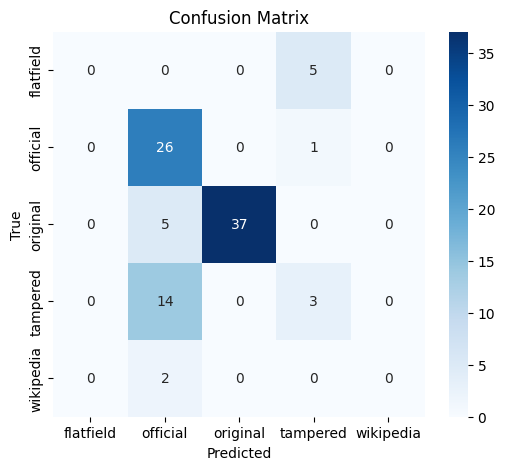

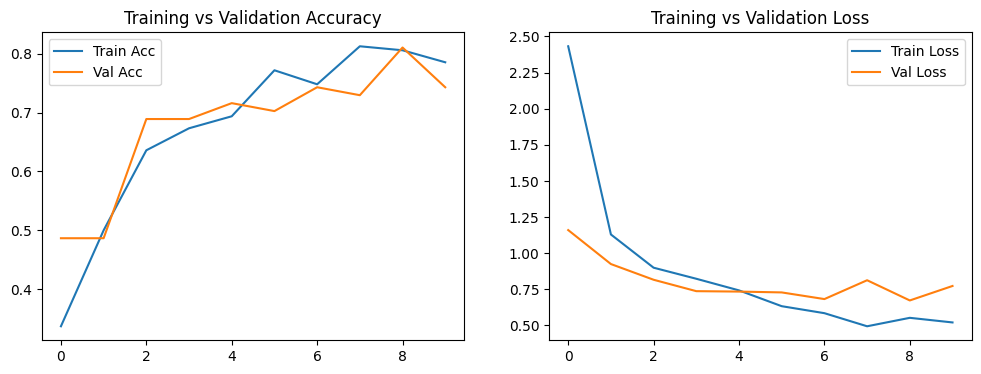

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# -----------------------------------
# Encode labels
# -----------------------------------
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc  = to_categorical(le.transform(y_test))

num_classes = len(le.classes_)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)

print("📌 Classes:", le.classes_)
print("✅ Encoded Labels:", dict(zip(le.classes_, range(num_classes))))

# -----------------------------------
# Baseline CNN Model
# -----------------------------------
def build_baseline_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_baseline_cnn(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -----------------------------------
# Train the Model
# -----------------------------------
history = model.fit(
    X_train, y_train_enc,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# -----------------------------------
# Evaluate the Model
# -----------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=0)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_enc, axis=1)

# Classification Report
print("\n📊 Classification Report:\n", classification_report(
    y_true_classes, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------------
# Training Curves
# -----------------------------------
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()
